In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops
from skimage.draw import polygon,rectangle,polygon_perimeter
import math
import os

In [2]:
path=r"data_1\0.jpg"
cropped_path=r"arbitrary\x.jpg"



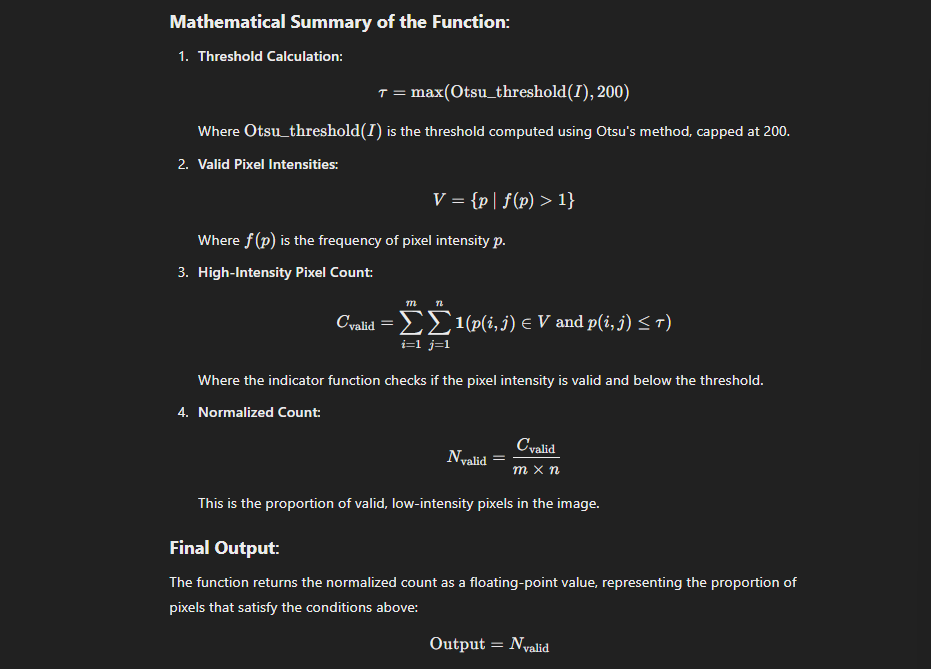

132
0.18398752012882447


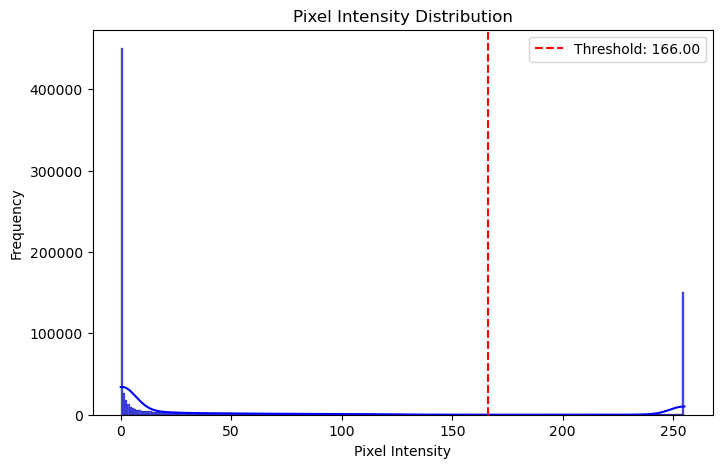

0.184

In [3]:
def Feature_1(image_path):
    '''
    this function processes an image to compute the percentage of pixels that have a 
    high intensity, based on a dynamic threshold and the frequency of pixel intensities,
    and visualizes this with a histogram plot.
    '''
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    
    # Calculate threshold using Otsu's method
    dynamic_threshold = threshold_otsu(image_array)
    print(dynamic_threshold)
    
    # Cap the threshold at a minimum of 200
    threshold = np.mean([dynamic_threshold, 200])

    # Compute the histogram of pixel intensities
    unique, counts = np.unique(image_array, return_counts=True)
    intensity_counts = dict(zip(unique, counts))

    # Identify values where the frequency is greater than 1
    valid_values = {val for val, freq in intensity_counts.items() if freq > 1}

    # Count pixels that are both above the threshold and meet the frequency condition
    high_intensity_count = np.sum([pixel in valid_values and pixel >= threshold for pixel in image_array.flatten()])
    
    # Normalize the count
    normalized_count = high_intensity_count / image_array.size
    print(normalized_count)
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(image_array.flatten(), bins=256, kde=True, color='blue', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return float(f"{normalized_count:.4f}")
Feature_1(path)

In [4]:
#Frobius Norm on entire Image

def Feature_2(image_path):
    '''
    this function calculates and returns the Frobenius norm of the grayscale version 
    of the image, which gives a numerical value representing the overall 
    intensity magnitude of the image.
    '''
    # Load the image and convert it to grayscale
    image = Image.open(image_path).convert("L")
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Compute the Frobenius norm
    frobenius_norm_value = np.linalg.norm(image_array, 'fro')
    
    return float(f"{frobenius_norm_value:.4f}")

Feature_2(path)

106401.598

In [5]:
def draw_line(r1, c1, r2, c2):
    """
    Generate pixel coordinates for a straight line between two points.
    """
    from skimage.draw import line
    return line(int(r1), int(c1), int(r2), int(c2))

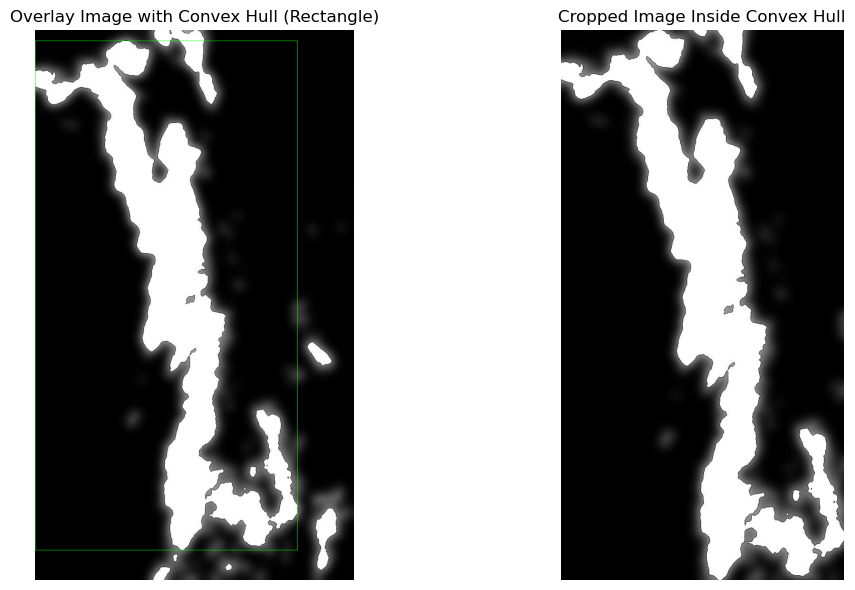

In [6]:

def crop(image_path):
    """
    Applies convex hull processing to the input image, crops the region inside the convex hull,
    shows the overlay image and cropped image side by side in subplots, and returns the cropped image.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        np.ndarray: Cropped image inside the convex hull.
    """
    cropped_path=r"arbitrary\x.jpg"
    
    # Load the image
    image = np.array(Image.open(image_path))
    if image.ndim == 3:  # If it's an RGB image
        gray_image = rgb2gray(image)  # Convert to grayscale
    else:
        gray_image = image  # If already grayscale
    
    # Binarize the image using Otsu's threshold
    threshold = threshold_otsu(gray_image)
    binary_image = gray_image >= threshold  # Convert to binary (foreground/background)
    
    # Label connected components (foreground objects)
    labeled_image, num_labels = label(binary_image, connectivity=2, return_num=True)
    
    # Calculate properties of the labeled regions (connected components)
    regions = regionprops(labeled_image)
    
    # Find the region with the largest area (most significant region)
    largest_region = max(regions, key=lambda r: r.area)
    
    # Get the coordinates of the largest region
    largest_region_coords = largest_region.coords
    
    # Compute the convex hull of the largest region's coordinates
    hull = ConvexHull(largest_region_coords)
    
    # Get the vertices of the convex hull
    hull_points = largest_region_coords[hull.vertices]
    
    # Create a mask from the convex hull
    mask = np.zeros_like(binary_image, dtype=bool)
    rr, cc = polygon(hull_points[:, 0], hull_points[:, 1], mask.shape)
    mask[rr, cc] = True
    
     # Create a bounding box (4-cornered box) around the convex hull
    min_row, min_col = hull_points.min(axis=0)
    max_row, max_col = hull_points.max(axis=0)
    box_corners = np.array([[min_row, min_col],
                            [min_row, max_col],
                            [max_row, max_col],
                            [max_row, min_col]])
    
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
    # Draw the box
    for i in range(len(box_corners)):
        start = box_corners[i]
        end = box_corners[(i + 1) % len(box_corners)]  # Next corner (wrap around)
        rr, cc = draw_line(start[0], start[1], end[0], end[1])
        overlay_image[rr, cc] = [0, 255, 0]  # Green color for the box
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
    # Draw the box
    for i in range(len(box_corners)):
        start = box_corners[i]
        end = box_corners[(i + 1) % len(box_corners)]  # Next corner (wrap around)
        rr, cc = draw_line(start[0], start[1], end[0], end[1])
        overlay_image[rr, cc] = [0, 255, 0]  # Green color for the box
    
    # Use the mask to extract the region inside the convex hull
    cropped_image = image[int(min_row):int(max_row), int(min_col):int(max_col)]
    
    # Create subplot with 2 images side by side
    plt.figure(figsize=(12, 6))  # Adjusted figure size for better clarity
    
    # Plot the overlay image with convex hull rectangle
    plt.subplot(1, 2, 1)  # (rows, cols, position)
    plt.imshow(overlay_image)
    plt.title('Overlay Image with Convex Hull (Rectangle)')
    plt.axis('off')
    
    # Plot the cropped image
    plt.subplot(1, 2, 2)  # (rows, cols, position)
    plt.imshow(cropped_image)
    plt.title('Cropped Image Inside Convex Hull')
    plt.axis('off')
    
    # Show the subplots
    plt.tight_layout()
    plt.show()
    
    # Save the cropped image as a new file
    cropped_image_pil = Image.fromarray(cropped_image)
    cropped_image_pil.save(cropped_path)
    
   

crop(path)

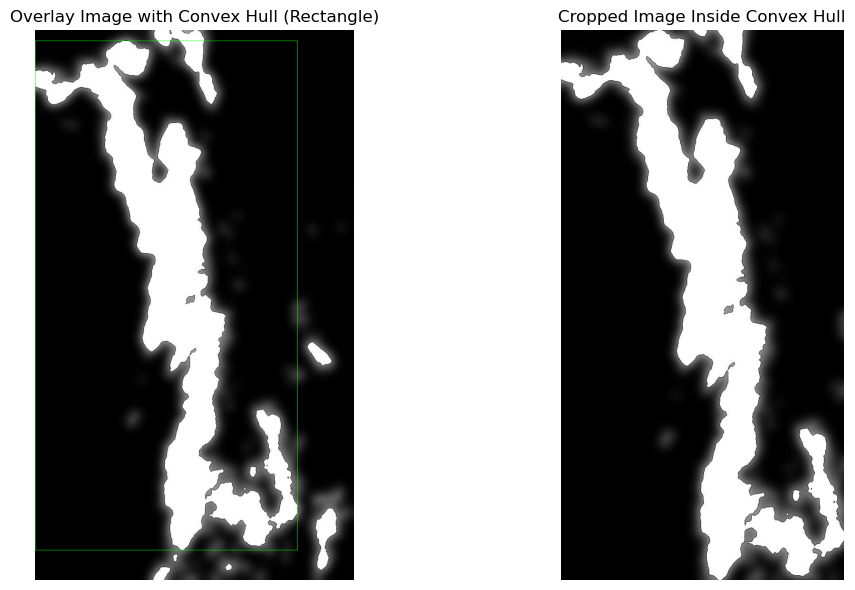

103157.1785

In [7]:
def Feature_3(path):
    '''
    The crop function processes an image by detecting the largest region, 
    computing its convex hull, cropping the image around the hull, 
    and displaying the original and cropped images side by side. 
    It then saves the cropped region to a new file, which can be used for 
    further analysis.
    '''
    crop(path)
    return Feature_2(cropped_path)

Feature_3(path)


In [8]:
def Feature_4():
    '''
    Feature_4 calculates and returns the diagonal length of the cropped image by applying 
    the Pythagorean theorem to the width and height of the image.
    '''
    path = r"arbitrary\x.jpg"  # Path to your image file
    
    # Open the image and get its dimensions
    image = Image.open(path)
    width, height = image.size  # width and height of the image
    
    # Calculate the diagonal length using Pythagorean theorem
    diagonal_length = math.sqrt(width**2 + height**2)
    
    return float(f"{diagonal_length:.4f}")
Feature_4()
# # Example usage
# diagonal = Feature_4()
# # print(diagonal)

1293.4311

In [9]:
def Feature_5():
    '''
    The Feature_5 function returns the width of the Cropped Image
    '''
    path = r"arbitrary\x.jpg"  # Path to your image file
    
    # Open the image and get its dimensions
    image = Image.open(path)
    width, height = image.size  # width and height of the image
    
    return width

# Example usage
width = Feature_5()
print(width)

592


In [10]:
def Feature_6():
    '''
    The Feature_6 function returns the height of the cropped image
    '''
    path = r"arbitrary\x.jpg"  # Path to your image file
    
    # Open the image and get its dimensions
    image = Image.open(path)
    width, height = image.size  # width and height of the image
    
    return height

# Example usage
height = Feature_6()
print(height)

1150


133
0.7705376028202116


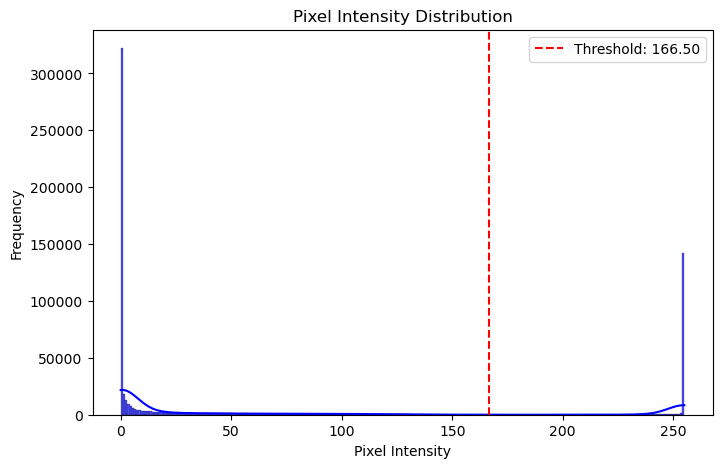

0.7705

In [11]:
def Feature_7():
    '''
    this function processes the Cropped image to compute the percentage of pixels that have a 
    lowest intensity, based on a dynamic threshold and the frequency of pixel intensities,
    and visualizes this with a histogram plot.
    '''
    image_path = r"arbitrary\x.jpg"
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    
    # Calculate threshold using Otsu's method
    dynamic_threshold = threshold_otsu(image_array)
    print(dynamic_threshold)
    
    # Cap the threshold at a minimum of 200
    threshold = np.mean([dynamic_threshold, 200])

    # Compute the histogram of pixel intensities
    unique, counts = np.unique(image_array, return_counts=True)
    intensity_counts = dict(zip(unique, counts))

    # Identify values where the frequency is greater than 1
    valid_values = {val for val, freq in intensity_counts.items() if freq > 1}

    # Count pixels that are both above the threshold and meet the frequency condition
    high_intensity_count = np.sum([pixel in valid_values and pixel <= threshold for pixel in image_array.flatten()])
    
    # Normalize the count
    normalized_count = high_intensity_count / image_array.size
    print(normalized_count)
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(image_array.flatten(), bins=256, kde=True, color='blue', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return float(f"{normalized_count:.4f}")
Feature_7()

In [14]:
def Feature_8(image_path):
    '''
    The function Feature_8 analyzes an image to calculate the ratio of white family 
    pixels to black family pixels based on a specified intensity threshold.
    '''
    image = Image.open(image_path).convert("L")
    image = np.array(image)
    # Define the threshold (127 by default)
    threshold = 127

    # Calculate the number of black and white family pixels
    black_family_pixels = np.sum(image <= threshold)
    white_family_pixels = np.sum(image > threshold)
    ratio=0.0
    # Calculate the ratio
    if white_family_pixels == 0:
        print("No white family pixels found. Ratio cannot be calculated.")
    else:
        ratio = white_family_pixels / black_family_pixels
        print(f"Ratio of black family to white family pixels: {ratio:.2f}")
    return float(f"{ratio:.4f}")
Feature_8(path)

Ratio of black family to white family pixels: 0.23


0.2313